# Netflix Movie Recommendation

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os
import random
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

<h1>  Exploratory Data Analysis </h1>

<h2>  Preprocessing</h2> 

<h3> Converting / Merging whole data to required format: u_i, m_j, r_ij</h3>

In [5]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] 
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00


In [2]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', nrows=10000, sep=',', names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [105]:
df.head()

,movie,user,rating,date
5015,7,1146420,1,2000-09-09
5064,7,1155825,1,2000-11-24
5025,7,767958,3,2000-12-06
5080,7,1602955,2,2000-12-08
5031,7,1476270,2,2000-12-09


In [106]:
df.describe()['rating']

count    10000.000000
mean         3.371200
std          1.274587
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

<h3> Checking for NaN values </h3>

In [107]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


<h3>Removing Duplicates </h3>

In [108]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) 
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


 <h3> Basic Statistics (#Ratings, #Users, and #Movies)</h3>

In [109]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 10000
Total No of Users   : 9627
Total No of movies  : 8


<h2> Spliting data into Train and Test(80:20) </h2>

In [110]:
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", nrows=1000, parse_dates=['date'])
test_df = pd.read_csv("test.csv", nrows=1000)

<h3>Basic Statistics in Train data (#Ratings, #Users, and #Movies)</h3>

In [111]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 1000
Total No of Users   : 24
Total No of movies  : 531


<h3> Basic Statistics in Test data (#Ratings, #Users, and #Movies)</h3>

In [112]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 1000
Total No of Users   : 829
Total No of movies  : 273


 <h2>  Exploratory Data Analysis on Train data </h2>

In [113]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<h3>  Distribution of ratings </h3>

<IPython.core.display.Javascript object>


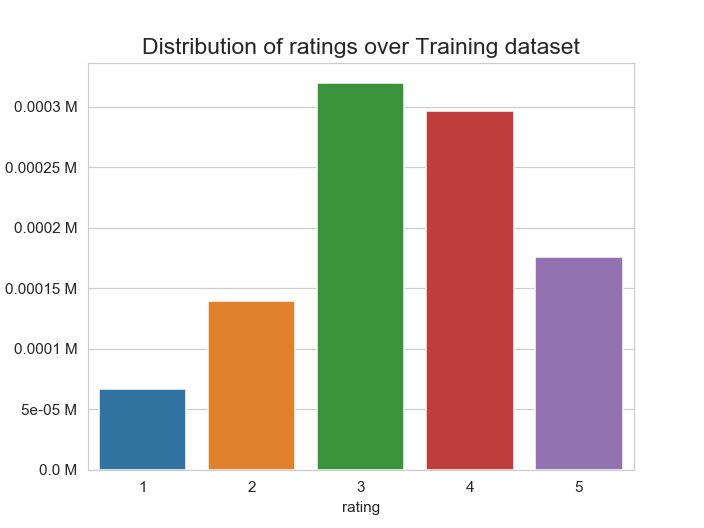

In [114]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

<p style="font-size:13px"> <b>Add new column (week day) to the data set  for analysis.</b></p>

In [115]:
pd.options.mode.chained_assignment = None  
train_df['day_of_week'] = train_df.date.dt.weekday_name
train_df.tail()

,movie,user,rating,date,day_of_week
995,9728,1972971,5,1999-12-28,Tuesday
996,11639,1394647,3,1999-12-29,Wednesday
997,15385,1394647,5,1999-12-29,Wednesday
998,7757,1587373,3,1999-12-29,Wednesday
999,7617,1394647,4,1999-12-29,Wednesday


<h3> 3.3.2 Number of Ratings per a month </h3>

<IPython.core.display.Javascript object>


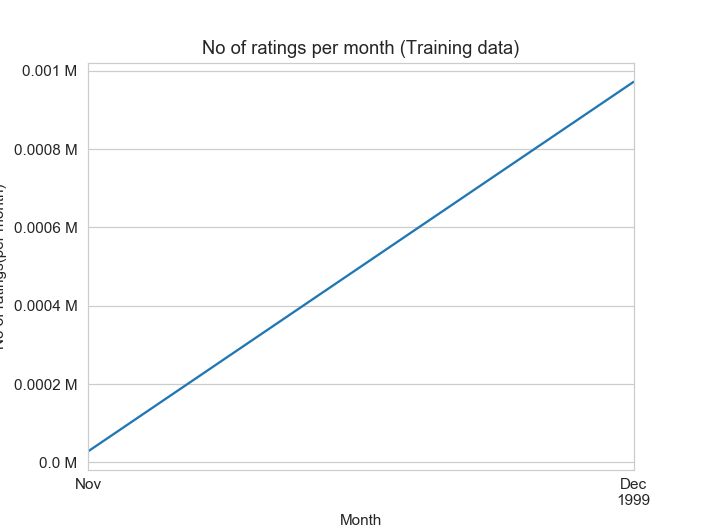

In [116]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<h3> 3.3.3 Analysis on the Ratings given by user </h3>

In [117]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
510180     169
731941     117
204439      99
1122804     86
122223      76
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


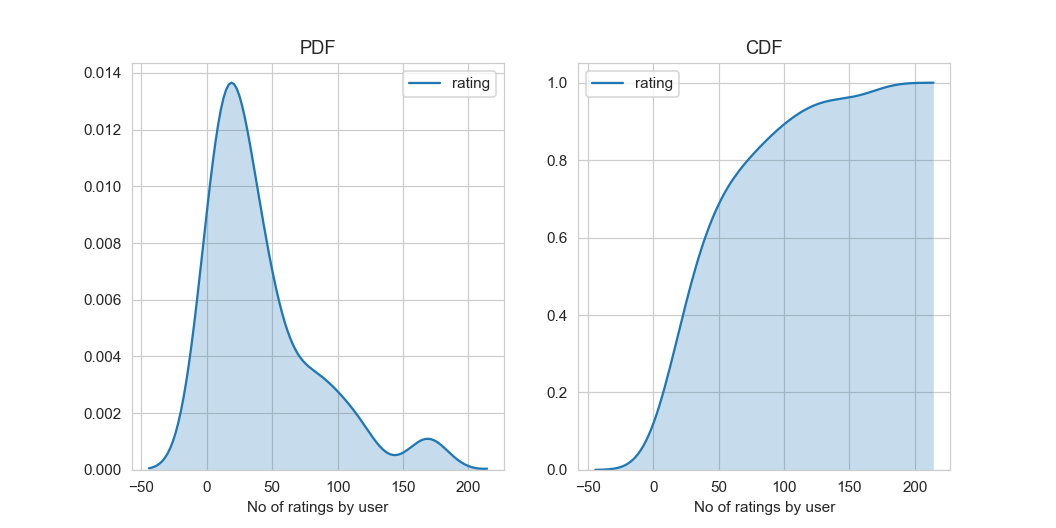

In [118]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [119]:
no_of_rated_movies_per_user.describe()

count     24.000000
mean      41.666667
std       41.744218
min        1.000000
25%       17.750000
50%       24.500000
75%       54.000000
max      169.000000
Name: rating, dtype: float64

> _There,  is something interesting going on with the quantiles.._

In [120]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<IPython.core.display.Javascript object>


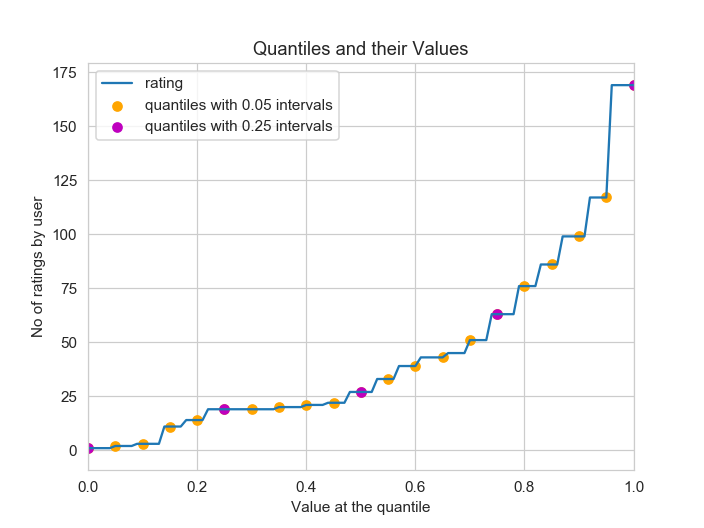

In [121]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [122]:
quantiles[::5]

0.00      1
0.05      2
0.10      3
0.15     11
0.20     14
0.25     19
0.30     19
0.35     20
0.40     21
0.45     22
0.50     27
0.55     33
0.60     39
0.65     43
0.70     51
0.75     63
0.80     76
0.85     86
0.90     99
0.95    117
1.00    169
Name: rating, dtype: int64

__how many ratings at the last 5% of all ratings__??

In [123]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)) )


 No of ratings at last 5 percentile : 0



<h3> 3.3.4 Analysis of ratings of a movie given by a user </h3>

<IPython.core.display.Javascript object>


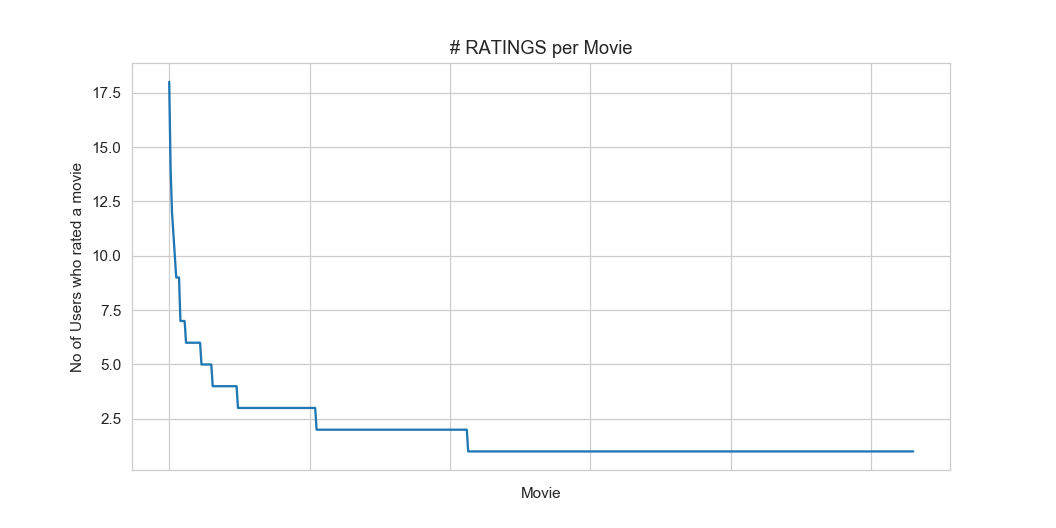

In [124]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

- __It is very skewed.. just like nunmber of ratings given per user.__
    
    
    - There are some movies (which are very popular) which are rated by huge number of users.
    
    - But most of the movies(like 90%) got some hundereds of ratings.

<h3> 3.3.5 Number of ratings on each day of the week</h3>

<IPython.core.display.Javascript object>


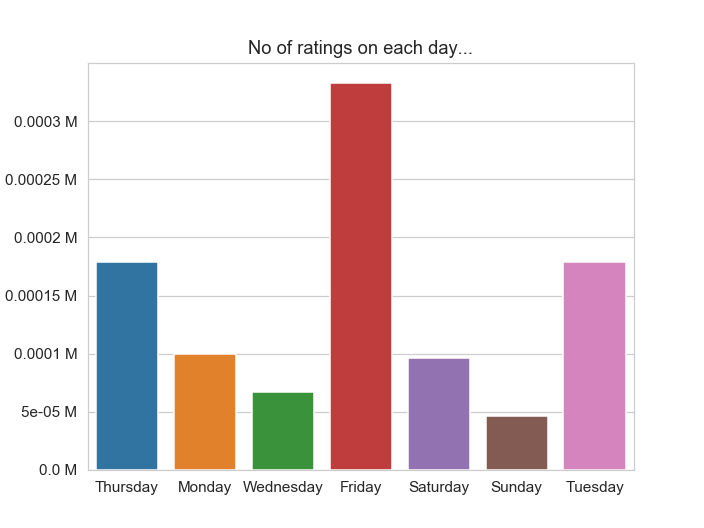

In [125]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


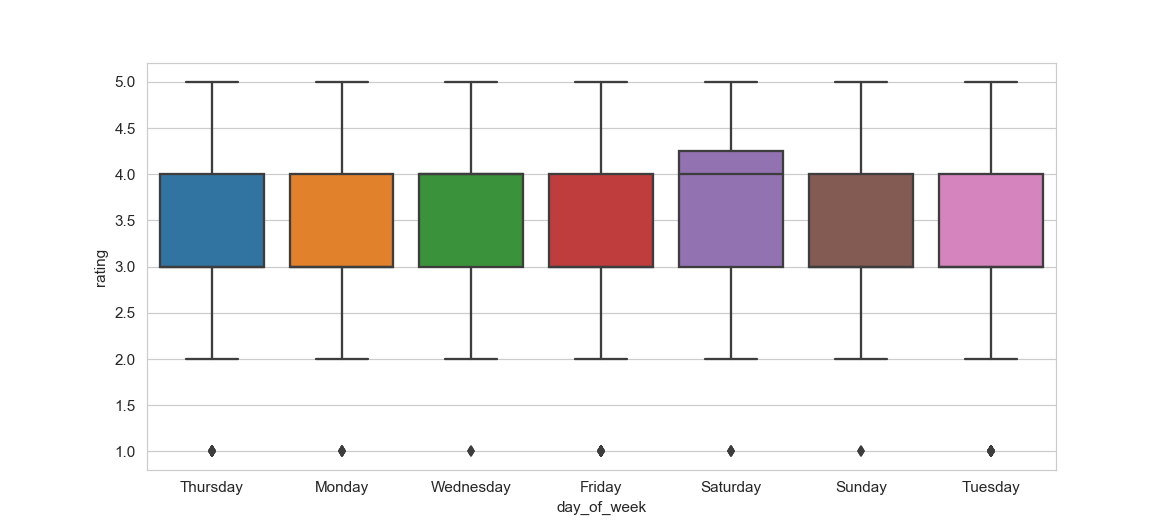

0:00:00.227925


In [126]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

In [127]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.348348
Monday       3.360000
Saturday     3.552083
Sunday       3.326087
Thursday     3.368715
Tuesday      3.284916
Wednesday    3.567164
Name: rating, dtype: float64




<h3> Creating sparse matrix from data frame </h3>

<h4> Creating sparse matrix from train data frame </h4>

In [7]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)   
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:05.954731


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [8]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


<h4>  Creating sparse matrix from test data frame </h4>

In [9]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))   
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:01.613522


<p><b>The Sparsity of Test data Matrix</b></p>

In [10]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()
print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


<h3>Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [11]:
def get_average_ratings(sparse_matrix, of_users):   
    ax = 1 if of_users else 0  
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    is_rated = sparse_matrix!=0
    no_of_ratings = is_rated.sum(axis=ax).A1
    u,m = sparse_matrix.shape
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}
    return average_ratings

<h4>  Finding global average of all movie ratings </h4>

In [12]:
train_averages = dict()
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

<h4> Finding average rating per user</h4>

In [13]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3781094527363185


<h4> Finding average rating per movie</h4>

In [14]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


<h4> PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)</h4>

In [51]:
start = datetime.now()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)
ax1.set_title('Users-Avg-Ratings')
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')
ax2.set_title('Movies-Avg-Rating')
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')
plt.show()
print(datetime.now() - start)

<IPython.core.display.Javascript object>

0:02:06.486040


<h3>  Cold Start problem </h3>

<h4> Cold Start problem with Users</h4>

In [52]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train
print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 988

Number of Users in Train data : 405041

No of Users that didn't appear in train data: -404053(-40896.05 %) 
 


<h4> Cold Start problem with Movies</h4>

In [53]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train
print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 3

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: -17421(-580700.0 %) 
 


<h2>  Computing Similarity matrices </h2>

<h3> Computing User-User Similarity matrix </h3>

<h4>  Trying with all dimensions</h4>

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list() 
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")    
    start = datetime.now()
    temp = 0    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
    if verbose: print('Creating Sparse matrix from the computed similarities')    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

In [55]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:02:16.422669  ]
computing done for 40 users [  time elapsed : 0:04:37.048661  ]
computing done for 60 users [  time elapsed : 0:06:47.976713  ]
computing done for 80 users [  time elapsed : 0:09:01.903745  ]
computing done for 100 users [  time elapsed : 0:11:17.658157  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>

----------------------------------------------------------------------------------------------------
Time taken : 0:11:43.443273


<h4> Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)</h4>

In [56]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD
start = datetime.now()
netflix_svd = TruncatedSVD(n_components=100, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)
print(datetime.now()-start)

0:12:13.598839


In [57]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
ind = [1, 2,4,8,20, 60, 100]#, 200, 300, 400, 500]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')
change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)
ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)
plt.show()

<IPython.core.display.Javascript object>

In [59]:
for i in ind:
    print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

(1, 0.23)
(2, 0.26)
(4, 0.3)
(8, 0.34)
(20, 0.38)
(60, 0.44)
(100, 0.47)


In [60]:
# Let's project our Original U_M matrix into into 500 Dimensional space...
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()- start)

0:00:11.401149


In [61]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 100))

In [62]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [63]:
trunc_sparse_matrix.shape

(2649430, 500)

In [ ]:
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, verbose=True, verb_for_n_rows=10)
print("-"*50)
print("time:",datetime.now()-start)

Computing top 50 similarities for each user..


<h3> Computing Movie-Movie Similarity matrix </h3>

In [ ]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")
print("It's a ",m_m_sim_sparse.shape," dimensional matrix")
print(datetime.now() - start)

In [ ]:
m_m_sim_sparse.shape

In [ ]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [ ]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

<h3> Finding most similar movies using similarity matrix </h3>

In [ ]:
movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")
movie_titles.head()

<p style='font-size:15px'><b>Similar Movies for 'Vampire Journals'</b></p>

In [ ]:
mv_id = 67
print("\nMovie ----->",movie_titles.loc[mv_id].values[1])
print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))
print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))

In [ ]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:] 

In [ ]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

__Top 10 similar movies__

In [ ]:
movie_titles.loc[sim_indices[:10]]

 <h1>  Machine Learning Models </h1>

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h2>  Sampling Data </h2>

<h3>Build sample train data from the train data</h3>

In [15]:
start = datetime.now()
path = "sample_train_sparse_matrix1.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users= 100, no_movies=50, path = path)
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.152913


In [16]:
sample_train_sparse_matrix

<2639276x16578 sparse matrix of type '<class 'numpy.int64'>'
	with 37 stored elements in Compressed Sparse Row format>

<h3>Build sample test data from the test data</h3>

In [17]:
start = datetime.now()
path = "sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=2500, no_movies=1500,
                                                 path = "sample_test_sparse_matrix.npz")
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.141918


<h2> Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h2>

In [18]:
sample_train_averages = dict()

<h3> Finding Global Average of all movie ratings</h3>

In [19]:
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.324324324324324}

<h3>Finding Average rating per User</h3>

In [20]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'])


Average rating of user 1515220 : {56409: 2.0, 100351: 4.0, 125275: 3.5, 134181: 3.0, 181321: 3.0, 294638: 4.0, 379927: 5.0, 413945: 4.0, 530721: 3.6, 730683: 5.0, 791026: 2.25, 1013474: 4.0, 1050678: 1.0, 1321121: 1.0, 1469830: 5.0, 1702272: 2.5, 1754027: 3.0, 1851951: 5.0, 1868586: 3.0, 2030103: 4.0, 2030535: 5.0, 2119151: 4.0, 2239141: 3.0, 2254991: 3.3333333333333335, 2612043: 3.0}


<h3>Finding Average rating per Movie</h3>

In [21]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'])


 AVerage rating of movie 15153 : {33: 4.0, 564: 3.0, 723: 2.75, 2732: 4.0, 3331: 3.75, 4783: 5.0, 6215: 4.0, 7146: 1.0, 7208: 3.75, 7645: 4.0, 9003: 3.2857142857142856, 9007: 3.0, 12092: 2.6666666666666665}


<h2>  Featurizing data </h2>

In [22]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 37


 No of ratings in Our Sampled test  matrix is : 7333



<h3> Featurizing data for regression problem </h3>

<h4>  Featurizing train data </h4>

In [23]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [24]:
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()       
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] 
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
           
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                  
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] 
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
       
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            row.append(sample_train_averages['user'][user])
            row.append(sample_train_averages['movie'][movie])
            row.append(rating)
            count = count + 1
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:               
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.001997


__Reading from the file to make a Train_dataframe__

In [25]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


<h4> Featurizing test data </h4>

In [26]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [27]:
sample_train_averages['global']

3.324324324324324

In [28]:
start = datetime.now()
if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()
            try:         
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] 
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            except (IndexError, KeyError):
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                raise
            try:       
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])            
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            row.append(rating)
            count = count + 1
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


In [29]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


<h3> Transforming data for Surprise models</h3>

In [30]:
from surprise import Reader, Dataset

<h4> Transforming train data </h4>

In [31]:
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
trainset = train_data.build_full_trainset() 

<h4>  Transforming test data </h4>

In [32]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

<h2> Applying Machine Learning models </h2>

In [34]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    train_results = dict()
    test_results = dict()
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
    return train_results, test_results   

In [35]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100


def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    train = dict()
    test = dict()
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    st = datetime.now()
    print('Evaluating the model with train data..')
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))

    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    st = datetime.now()
    print('\nEvaluating for test data...')
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    return train, test

<h3> XGBoost with initial 13 features </h3>

In [67]:
import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

# Hyper Parameter For XGBoost

Tuning parameters: 

Time taken to tune:0:13:18.817064

Training the model..
Done. Time taken : 0:01:27.726609

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0936951006118867
MAPE :  33.63449881914459


<IPython.core.display.Javascript object>


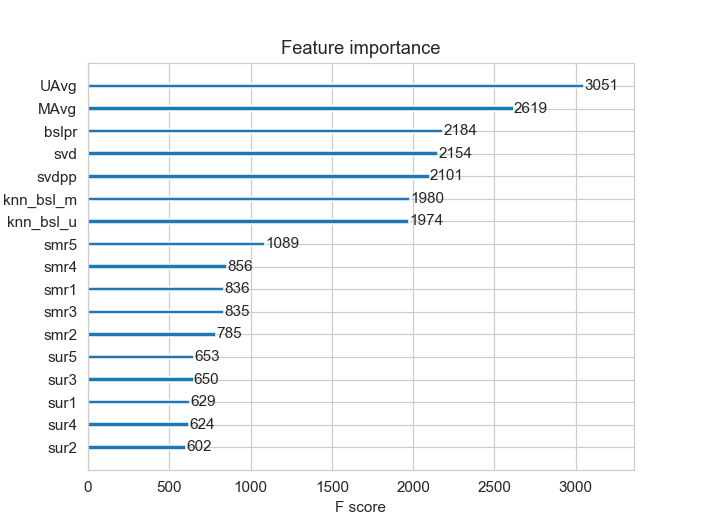

In [69]:
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# Hyperparameter tuning 
params = {'learning_rate' :stats.uniform(0.01,0.2),'n_estimators':sp_randint(100,1000),'max_depth':sp_randint(1,10),
             'reg_alpha':sp_randint(0,200)}

xgbreg = xgb.XGBRegressor(silent=True, n_jobs= -1, random_state=15)
start =datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, param_distributions= params,refit=False, scoring = "neg_mean_squared_error", cv =3,n_jobs = -1)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
first_xgb = xgbreg.set_params(**best_para)
print('Time taken to tune:{}\n'.format(datetime.now()-start))
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results
xgb.plot_importance(first_xgb)
plt.show()

<h3> Suprise BaselineModel </h3>

In [70]:
from surprise import BaselineOnly 

In [71]:
bsl_options = {'method': 'sgd','learning_rate': .001}
bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:01.068594 

Evaluating the model with train data..
time taken : 0:00:01.722712
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.218734
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:03.025649


<h3>  XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [72]:
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,...,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,...,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302,3.278967,3.538247


__Updating Test Data__

In [73]:
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


# Hyper Parameter Tuning

Tuning parameters: 

Time taken to tune:0:09:21.963230

Training the model..
Done. Time taken : 0:01:24.754385

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.126439148473546
MAPE :  32.70538436753613


<IPython.core.display.Javascript object>


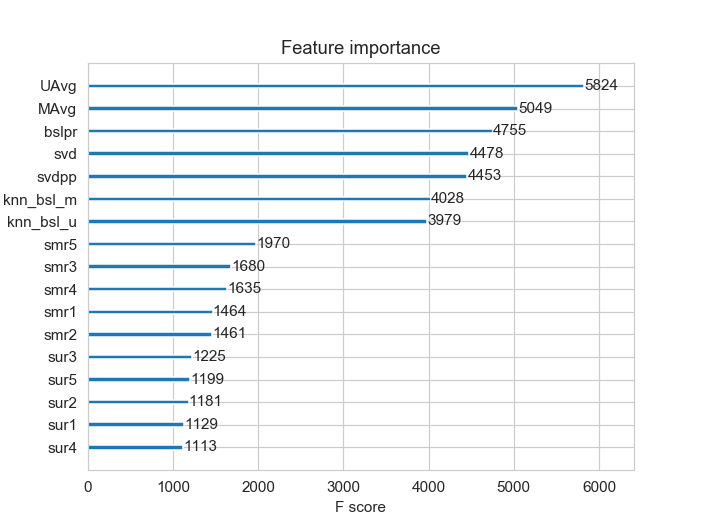

In [75]:
#https://github.com/nishantml/NETFLIX-MOVIE-RECOMMENDATION-SYSTEM/blob/master/Netflix_Movie.ipynb
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),'n_estimators':sp_randint(100,1000),'max_depth':sp_randint(1,10),
           'reg_alpha':sp_randint(0,200)}
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start =datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, param_distributions= params,refit=False, n_jobs=-1,scoring = "neg_mean_squared_error",
                              cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
xgb_bsl = xgbreg.set_params(**best_para)
print('Time taken to tune:{}\n'.format(datetime.now()-start))
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results
xgb.plot_importance(xgb_bsl)
plt.show()

<h3> Surprise KNNBaseline predictor </h3>

In [76]:
from surprise import KNNBaseline

  <h4> Surprise KNNBaseline with user user similarities</h4>

In [77]:
sim_options = {'user_based' : True,'name': 'pearson_baseline', 'shrinkage': 100, 'min_support': 2} 
bsl_options = {'method': 'sgd'} 
knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:59.800445 

Evaluating the model with train data..
time taken : 0:03:36.655839
---------------
Train Data
---------------
RMSE : 0.33642097416508826

MAPE : 9.145093375416348

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.171956
---------------
Test Data
---------------
RMSE : 1.0726493739667242

MAPE : 35.02094499698424

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:04:36.636240


<h4> Surprise KNNBaseline with movie movie similarities</h4>

In [78]:
sim_options = {'user_based' : False,'name': 'pearson_baseline', 'shrinkage': 100, 'min_support': 2} 
bsl_options = {'method': 'sgd'}
knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:02.347787 

Evaluating the model with train data..
time taken : 0:00:19.030137
---------------
Train Data
---------------
RMSE : 0.32584796251610554

MAPE : 8.447062581998374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.156240
---------------
Test Data
---------------
RMSE : 1.072758832653683

MAPE : 35.02269653015042

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:21.534164


<h3>  XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

In [79]:
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,...,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,...,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302,3.278967,3.538247


In [80]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


# Hyper Parameter Tuning

Tuning parameters: 

Time taken to tune:0:08:59.834482

Training the model..
Done. Time taken : 0:01:13.478132

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0836231506652356
MAPE :  34.0380567413844


<IPython.core.display.Javascript object>


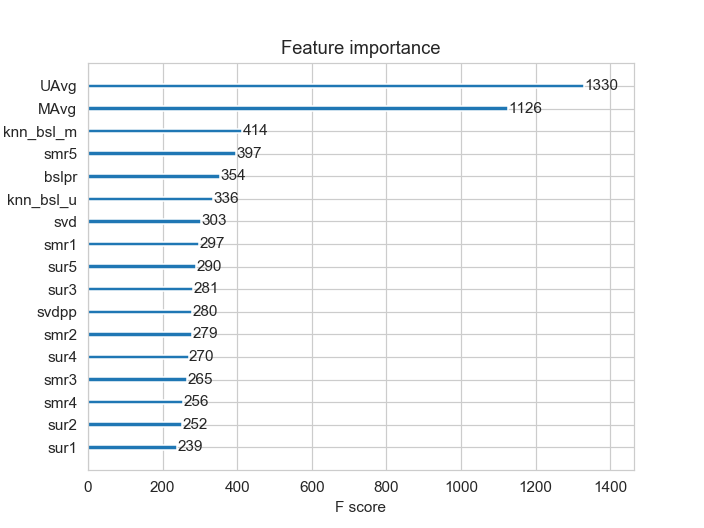

In [82]:
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']
params = {'learning_rate' :stats.uniform(0.01,0.2),'n_estimators':sp_randint(100,1000),'max_depth':sp_randint(1,10),'reg_alpha':sp_randint(0,200)}
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start =datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, param_distributions= params,refit=False, scoring = "neg_mean_squared_error",n_jobs=-1,
                              cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
xgb_knn_bsl = xgbreg.set_params(**best_para)
print('Time taken to tune:{}\n'.format(datetime.now()-start))
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results
xgb.plot_importance(xgb_knn_bsl)
plt.show()

<h3>  Matrix Factorization Techniques </h3>

<h4>  SVD Matrix Factorization User Movie intractions </h4>

In [83]:
from surprise import SVD

In [84]:
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:16.884817 

Evaluating the model with train data..
time taken : 0:00:02.291246
---------------
Train Data
---------------
RMSE : 0.6574721240954099

MAPE : 19.704901088660478

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.131265
---------------
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:19.322958


  <h4>SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [85]:
from surprise import SVDpp

In [86]:
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:04:06.409951 

Evaluating the model with train data..
time taken : 0:00:10.119468
---------------
Train Data
---------------
RMSE : 0.6032438403305899

MAPE : 17.49285063490268

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.124990
---------------
Test Data
---------------
RMSE : 1.0728491944183447

MAPE : 35.03817913919887

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:04:16.654409


<h3> XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [87]:
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,...,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,...,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302,3.278967,3.538247


#### Preparing Test data

In [88]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']
reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


# Hyper Parameter Tuning

Tuning parameters: 

Time taken to tune:0:07:49.156158

Training the model..
Done. Time taken : 0:01:31.372603

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1149433521691665
MAPE :  32.99453879623036


<IPython.core.display.Javascript object>


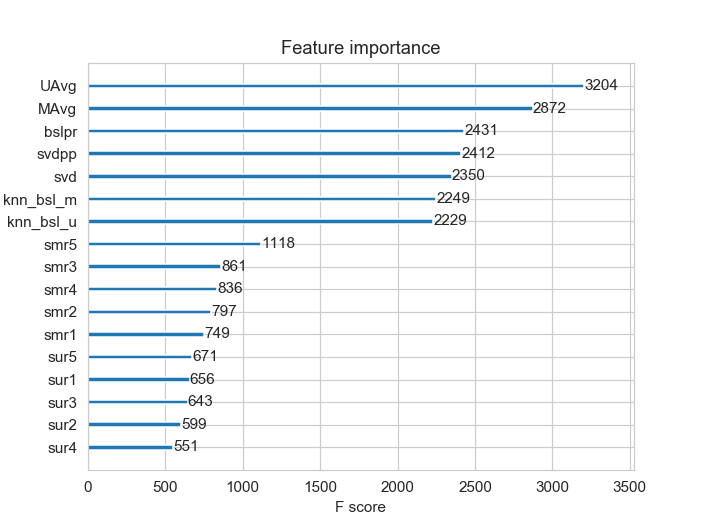

In [90]:
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']
params = {'learning_rate' :stats.uniform(0.01,0.2), 'n_estimators':sp_randint(100,1000), 'max_depth':sp_randint(1,10),'reg_alpha':sp_randint(0,200)}
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start =datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, param_distributions= params,refit=False, scoring = "neg_mean_squared_error",n_jobs=-1,
                              cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
xgb_final = xgbreg.set_params(**best_para)
print('Time taken to tune:{}\n'.format(datetime.now()-start))
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results
xgb.plot_importance(xgb_final)
plt.show()

<h3>  XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

# Hyper PArameter Tuning

Tuning parameters: 

Tuning parameters: 

Training the model..
Done. Time taken : 0:00:09.153142

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0752094852494265
MAPE :  35.09573774688043


<IPython.core.display.Javascript object>


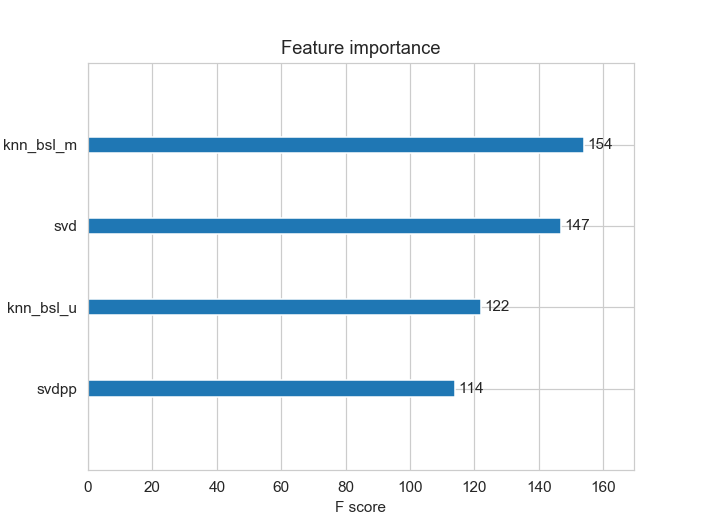

In [94]:
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']
params = {'learning_rate' :stats.uniform(0.01,0.2),'n_estimators':sp_randint(100,1000), 'max_depth':sp_randint(1,10), 'reg_alpha':sp_randint(0,200)}
xgbreg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=15)
start =datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, param_distributions= params,refit=False, scoring = "neg_mean_squared_error",n_jobs=-1,
                              cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']
xgb_all_models = xgbreg.set_params(**best_para)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results
xgb.plot_importance(xgb_all_models)
plt.show()

<h2>  Comparision between all models </h2>

In [1]:
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

In [4]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Set", "TEST DATA-RMSE"]
x.add_row(["First_Algorithem",  1.0936951006118867])
x.add_row(["bsl_Algorithem", 1.0730330260516174])
x.add_row(["xgd_bsl_Algorithem",  1.126439148473546])
x.add_row(["knn_bsl_u",  1.0726493739667242])
x.add_row(["knn_bsl_m", 1.072758832653683])
x.add_row(["xgd_knn_bsl", 1.0836231506652356])
x.add_row(["svd", 1.0726046873826458])
x.add_row(["svdpp", 1.0728491944183447])
x.add_row(["xgd_final", 1.1149433521691665])
x.add_row(["xgd_all_models",  1.0752094852494265])

print(x)

+--------------------+--------------------+
|        Set         |   TEST DATA-RMSE   |
+--------------------+--------------------+
|  First_Algorithem  | 1.0936951006118867 |
|   bsl_Algorithem   | 1.0730330260516174 |
| xgd_bsl_Algorithem | 1.126439148473546  |
|     knn_bsl_u      | 1.0726493739667242 |
|     knn_bsl_m      | 1.072758832653683  |
|    xgd_knn_bsl     | 1.0836231506652356 |
|        svd         | 1.0726046873826458 |
|       svdpp        | 1.0728491944183447 |
|     xgd_final      | 1.1149433521691665 |
|   xgd_all_models   | 1.0752094852494265 |
+--------------------+--------------------+


# Conclusion:-

1. First preprocessing all file merging whole data to required format: u_i, m_j, r_ij, and after that maerge all file into one data file.
2. Then checking null values and check there is any duplication in it.
3. Then spliting data in to 80-30% into train data and test data where in train file contain no's of movies, rating and users and test data also contain no's of movies , rating, and users.
4. Then did Exploratory Data Analysis on Train data where calculate distribution per week and no's of ratings given by raters and then plot cdf and pdf both for train data.
5. Then did Analysis of ratings of a movie given by a user, Number of ratings on each day of the week, for test data.
6. Then did Creating sparse matrix from data frame ,Creating sparse matrix from train data frame , The Sparsity of Train Sparse Matrix.
7. Then Creating sparse matrix from test data frame , the Sparsity of Test data Matrix for test data.
8. Then Finding Global average of all movie ratings, Average rating per user, and Average rating per movie, finding global average of all movie ratings , finding average rating per user,  finding average rating per movie, PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data).
9. Then Cold Start problem for user and movies.
10. Then Computing User-User Similarity matrix , and Computing Movie-Movie Similarity matrix and  Finding most similar movies using similarity matrix.
11. Then applied Machine Learning Models like XGBoost with initial 13 features, Suprise BaselineModel , XGBoost with initial 13 features + Surprise Baseline predictor using train data and test data, Surprise KNNBaseline predictor, XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor, Matrix Factorization Techniques , XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques ,XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques.

<h1>================================================================= </h1>